# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [3]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [5]:
class Config():
    training_dir = "/home/bhm/Downloads/FSSN/data/faces/training/"
    testing_dir = "/home/bhm/Downloads/FSSN/data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [7]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '/home/bhm/Downloads/FSSN/data/faces/training/'

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

/home/bhm/.pyenv/versions/3.9.16/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


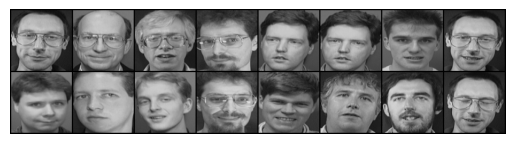

[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/home/bhm/.pyenv/versions/3.9.16/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.711139440536499

Epoch number 1
 Current loss 3.7619597911834717

Epoch number 2
 Current loss 2.615952491760254

Epoch number 3
 Current loss 1.4215552806854248

Epoch number 4
 Current loss 0.6857138872146606

Epoch number 5
 Current loss 0.5808616876602173

Epoch number 6
 Current loss 0.3618987798690796

Epoch number 7
 Current loss 0.39333292841911316

Epoch number 8
 Current loss 0.20709700882434845

Epoch number 9
 Current loss 0.17988303303718567

Epoch number 10
 Current loss 0.22581088542938232

Epoch number 11
 Current loss 0.16770927608013153

Epoch number 12
 Current loss 0.09468931704759598

Epoch number 13
 Current loss 0.10969844460487366

Epoch number 14
 Current loss 0.11716556549072266

Epoch number 15
 Current loss 0.136606827378273

Epoch number 16
 Current loss 0.12848514318466187

Epoch number 17
 Current loss 0.12651444971561432

Epoch number 18
 Current loss 0.10124950110912323

Epoch number 19
 Current loss 0.06062525138258934

E

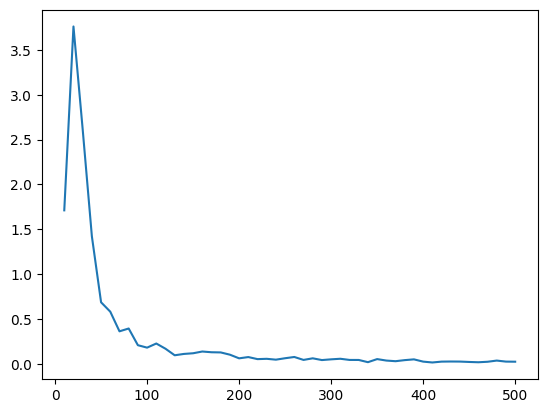

In [ ]:
for epoch in range(0,Config.train_number_epochs - 50):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

[[-0.9686215   0.5542512   1.1931763  -1.4029528  -0.24500675]] tensor([[-0.2659,  0.8700,  1.2931, -1.1035,  0.8369]]) 1.3651952743530273


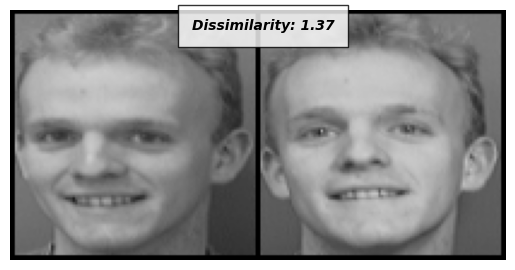

[[-0.9686215   0.5542512   1.1931763  -1.4029528  -0.24500675]] tensor([[-0.2189, -0.4772,  0.8058, -0.1623,  0.0632]]) 1.8466600179672241


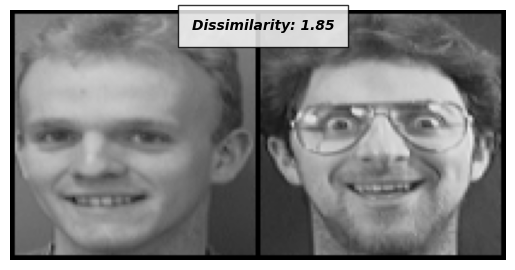

[[-0.9686215   0.5542512   1.1931763  -1.4029528  -0.24500675]] tensor([[ 0.3169, -0.3101,  0.3887,  0.1979, -0.6302]]) 2.399529218673706


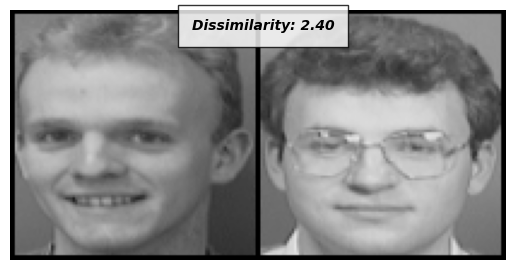

[tensor([[-0.9686,  0.5543,  1.1932, -1.4030, -0.2450]]), tensor([[-0.9686,  0.5543,  1.1932, -1.4030, -0.2450]]), tensor([[-0.9686,  0.5543,  1.1932, -1.4030, -0.2450]])]


In [ ]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)
net.eval()
xxx = []
with torch.no_grad():
    for i in range(3):
        _,x1,label2 = next(dataiter)
        concatenated = torch.cat((x0,x1),0)
        
        # output1,output2 = net(Variable(x0),Variable(x1))
        output1 = net.forward_once(x0)
        output2 = net.forward_once(x1)
        xxx.append(output1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        print(output1.detach().numpy(), output2.detach(), euclidean_distance.item())
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
print(xxx)


In [ ]:
torch.save(net.state_dict(), 'model2.pth')

NameError: name 'torch' is not defined

In [ ]:
#net = SiameseNetwork()
net.load_state_dict(torch.load('model2.pth'))

<All keys matched successfully>

In [ ]:
from tkinter import *
import imutils
import cv2
from PIL import Image
from PIL import ImageTk

In [ ]:
test_dir = 'test'
test_data = dset.ImageFolder(test_dir, transform=transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((100,100)),
    transforms.ToTensor()
    ])
)
test_loader = DataLoader(test_data)
classes = test_data.classes
net = SiameseNetwork()


net.eval()
with torch.no_grad():
    test_list = []
    for data in test_loader:
        img1, label = data
        output2 = net.forward_once(img1)
        test_list.append([output2, label])


for i in test_list:
    print(i)
#######################################################
def img_update(frame):
    # 촬영된 이미지를 레이블에 업데이트
    img = imutils.resize(frame, width=WIDTH_CAM)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = ImageTk.PhotoImage(image=img)
    label1.configure(image=img)
    label1.img = img

def test_camera():
    global cap
    
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, WIDTH_CAM)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, HEIGHT_CAM)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            if len(faces):
                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    img0 = gray[y : y+h, x : x+w]
                    name, color = face_detection(img0)
                    cv2.putText(frame, f'{name}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    label2.configure(text='Face Found', fg="black")
            else:
                label2.configure(text="Face Not Found", fg="dimgray")
            
            img_update(frame)  # 이미지 업데이트
            root.update()


def face_detection(img0):  # 얼굴 비교
    img0 = torch.from_numpy(img0).float() / 255.0
    img0 = img0.unsqueeze(0).unsqueeze(0)
    img0 = transforms.Resize((100, 100))(img0)

    net.eval()
    with torch.no_grad():
        name = None
        output1 = net.forward_once(img0)
        for data in test_list:
            output2, label = data
            euclidean_distance = F.pairwise_distance(output1, output2)
            if euclidean_distance.item() < 2**(1/2):
                name = classes[label.item()]
                color = (255, 255, 255)
                break
    if name is None:
        name = '[UNKNOWN]'
        color = (0, 0, 255)
    return name, color

def exit():
    try:
        cap.release()
    except:
        pass
    root.destroy()


DELAY_CAM = 100
DELAY_END = 2000
WIDTH = 800
HEIGHT = 450
WIDTH_CAM = 400
HEIGHT_CAM = 300

# UI 초기화
root = Tk()
root.protocol("WM_DELETE_WINDOW", exit)
root.minsize(WIDTH, HEIGHT)

label1 = Label(root, bitmap="hourglass", bd=3, width=WIDTH_CAM, height=HEIGHT_CAM, relief="ridge")
label1.place(relx=0.5, rely=0.35, anchor=CENTER)
label2 = Label(root, bd=2, font=("Calibri",30))
label2.place(relx=0.5, rely=0.8, anchor=CENTER)
button1 = Button(root, text="Exit", height=2, font=("Calibri", 20), command=exit)
button1.place(relx=0.8, rely=0.9, anchor=CENTER)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
root.after(DELAY_CAM*5, test_camera)

root.mainloop()
